In [1]:
import pandas as pd 
import numpy as np

# Load the datasets
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [2]:
# Join the two dataset on the 'id' column
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [3]:
df2.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


Demographic Filtering
---------------------

In [4]:
C= df2['vote_average'].mean()
C

6.092171559442011

In [5]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

In [6]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

IMDB's weighted rating (wr)
https://tutorialedge.net/python/building-imdb-top-250-clone-pandas/#the-metric

- v is the number of votes for the movie;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the movie; And
- C is the mean vote across the whole report

In [7]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [8]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [9]:
import matplotlib.pyplot as plt

In [10]:
# Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

# Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score', 'popularity']].head(15)

,title,vote_count,vote_average,score,popularity
1881,The Shawshank Redemption,8205,8.5,8.059258,136.747729
662,Fight Club,9413,8.3,7.939256,146.757391
65,The Dark Knight,12002,8.2,7.920020,187.322927
3232,Pulp Fiction,8428,8.3,7.904645,121.463076
96,Inception,13752,8.1,7.863239,167.583710
3337,The Godfather,5893,8.4,7.851236,143.659698
95,Interstellar,10867,8.1,7.809479,724.247784
809,Forrest Gump,7927,8.2,7.803188,138.133331
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243,123.630332
1990,The Empire Strikes Back,5879,8.2,7.697884,78.517830


Text(0.5,1,'Trending Movies')

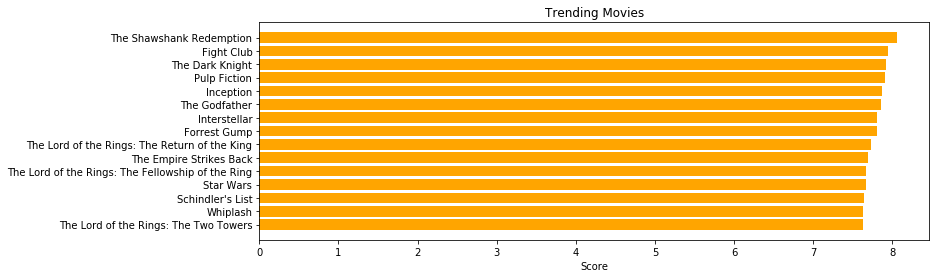

In [11]:
plt.figure(figsize=(12,4))

plt.barh(q_movies['title'].head(15), q_movies['score'].head(15), align='center', color='orange')
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Trending Movies")

Text(0.5,1,'Popular Movies')

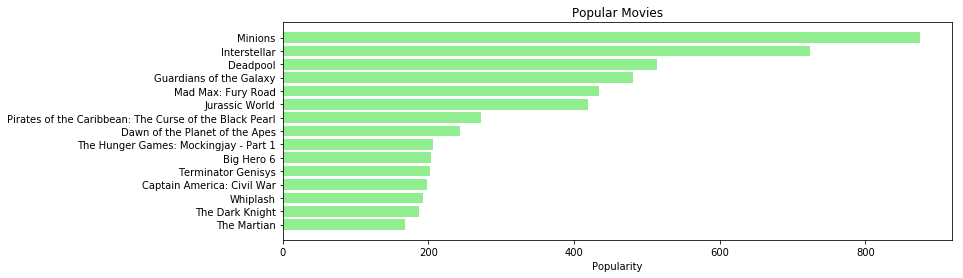

In [12]:
pop= df2.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(15), pop['popularity'].head(15), align='center', color='lightgreen')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

Content Based Filtering
-----------------------

In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

In [13]:
df2['overview'].head(10)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
5    The seemingly invincible Spider-Man goes up ag...
6    When the kingdom's most wanted-and most charmi...
7    When Tony Stark tries to jumpstart a dormant p...
8    As Harry begins his sixth year at Hogwarts, he...
9    Fearing the actions of a god-like Super Hero l...
Name: overview, dtype: object

In [14]:
# Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#,Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

In [15]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [16]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [17]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    try:
        # Get the index of the movie that matches the title
        idx = indices[title]
    except:
        return 'Cannot find the index of the movie that matches the title'

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    try:
        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    except:
        pass

    # Get the scores of the 10 most similar movies
    if len(sim_scores) > 11:
        sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2[['title', 'release_date', 'id']].iloc[movie_indices]

In [18]:
get_recommendations('Spider-Man')

,title,release_date,id
5,Spider-Man 3,2007-05-01,559
38,The Amazing Spider-Man 2,2014-04-16,102382
20,The Amazing Spider-Man,2012-06-27,1930
30,Spider-Man 2,2004-06-25,558
1534,Arachnophobia,1990-08-09,6488
953,Gremlins 2: The New Batch,1990-06-15,928
1720,Kick-Ass,2010-03-22,23483
2740,The New Guy,2002-05-10,10985
3216,Election,1999-04-23,9451
1572,Forgetting Sarah Marshall,2008-04-17,9870


In [19]:
get_recommendations('Superman')

,title,release_date,id
870,Superman II,1980-12-04,8536
10,Superman Returns,2006-06-28,1452
2433,Superman IV: The Quest for Peace,1987-07-23,11411
914,Central Intelligence,2016-06-15,302699
4659,Horse Camp,2015-01-10,306667
2527,National Lampoon's Vacation,1983-07-28,11153
3542,R100,2013-10-05,193722
45,World War Z,2013-06-20,72190
1368,Identity Thief,2013-02-07,109431
1237,The Out-of-Towners,1999-04-02,8970
